# EPIC 키워드 추이

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from collections import Counter

plt.rc('font', family='Malgun Gothic')
font_path = r"C:/windows/fonts/malgun.ttf"

# 데이터 불러오기

In [2]:
file_path = "../data/"
fn= 'epic_data.xlsx'

raw_df = pd.read_excel(file_path+fn)

재시작 점

---------------------------------

In [101]:
df = raw_df[['발간처','자료명', '발간일','요약']].sort_values('발간일').reset_index(drop=True)

# 키워드 설정

In [102]:
keywords = ['저출산','인구감소','인구 감소','저출생','인구부족']
# 복수 키워드 가능. 단 or 기준

In [103]:
# 해당 컬럼에 지정된 단어가 포함되어 있는지 확인하는 함수
def contains_keyword(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords))
    return 0  # If not a string, return 0

In [104]:
# 요약에 포함되어 있는지 여부
df['포함_요약'] = df['요약'].apply(contains_keyword)
# 제목에 포함되어 있는지 여부
df['포함_제목'] = df['자료명'].apply(contains_keyword)

# 날짜 설정

In [105]:
start_date = '1996-01-01'
end_date = '2024-05-31'

In [106]:
# 날짜 형식을 datetime 형식으로 변환하는 함수
def convert_to_datetime(date_str):
    # 'yyyy.mm.' 형식인 경우
    if len(date_str) == 8 and date_str[-1] == '.':
        date_str += '01'
    # 'yyyy.mm.dd' 형식이 아니거나, 잘못된 형식인 경우 None 반환
    elif len(date_str) != 10 or not date_str.replace('.', '').isdigit():
        return None
    
    # 유효하지 않은 일자 확인 및 수정
    try:
        date = pd.to_datetime(date_str, format='%Y.%m.%d', errors='raise')
        # 유효하지 않은 월이나 일을 가진 경우 None 반환
        if date.month == 0 or date.day == 0:
            return None
    except ValueError:
        # 잘못된 날짜는 'yyyy.mm.01'로 수정
        date_str = date_str[:8] + '01'
        try:
            date = pd.to_datetime(date_str, format='%Y.%m.%d')
        except ValueError:
            return None
    return date

In [107]:
# '발간일' 컬럼을 datetime 형식으로 변환
df['발간일'] = df['발간일'].apply(convert_to_datetime)

In [108]:
# 필요 날짜만 고르자.
df = df[(df['발간일'] >= start_date) & (df['발간일'] <= end_date)]

# 검색 카운트

In [109]:
def count_by_period(data, period, from_summary=True):
    if period == 'daily':
        counts = data.groupby(data['발간일'].dt.date)['포함_요약'].agg(['count', 'sum'])
    elif period == 'monthly':
        counts = data.groupby(data['발간일'].dt.to_period('M'))['포함_요약'].agg(['count', 'sum'])
    elif period == 'annually':
        counts = data.groupby(data['발간일'].dt.to_period('Y'))['포함_요약'].agg(['count', 'sum'])
    else:
        raise ValueError("Invalid period. Choose from 'daily', 'monthly', or 'annually'.")

    if from_summary is not True:
        if period == 'daily':
            counts = data.groupby(data['발간일'].dt.date)['포함_제목'].agg(['count', 'sum'])
        elif period == 'monthly':
            counts = data.groupby(data['발간일'].dt.to_period('M'))['포함_제목'].agg(['count', 'sum'])
        elif period == 'annually':
            counts = data.groupby(data['발간일'].dt.to_period('Y'))['포함_제목'].agg(['count', 'sum'])
        else:
            raise ValueError("Invalid period. Choose from 'daily', 'monthly', or 'annually'.")
        
    counts.columns = ['total_count', 'keyword_count']
    
    counts_keyword = counts['keyword_count']
    return counts_keyword

In [110]:
daily_keywords = count_by_period(df, 'daily', from_summary=True)
monthly_keywords = count_by_period(df, 'monthly', from_summary=True)
annual_keywords = count_by_period(df, 'annually', from_summary=True)

# 시각화

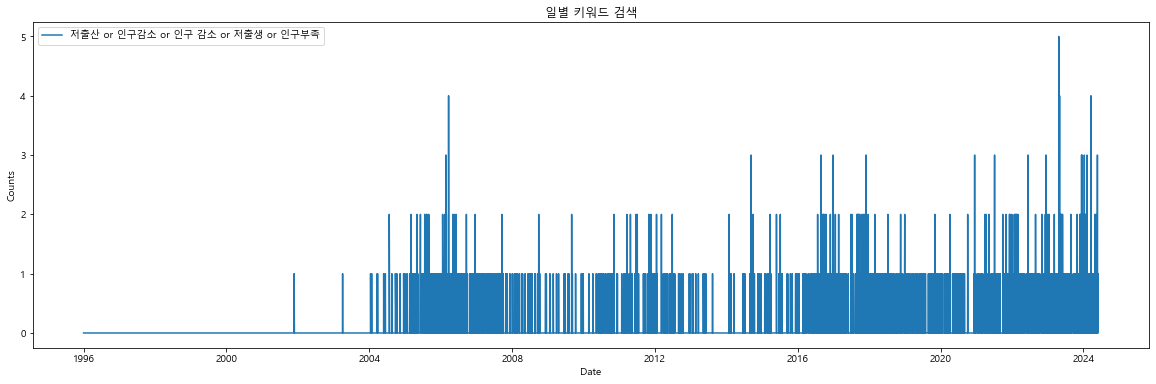

In [111]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
daily_keywords.plot()
plt.title('일별 키워드 검색')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend([" or ".join(keywords)])
plt.show()

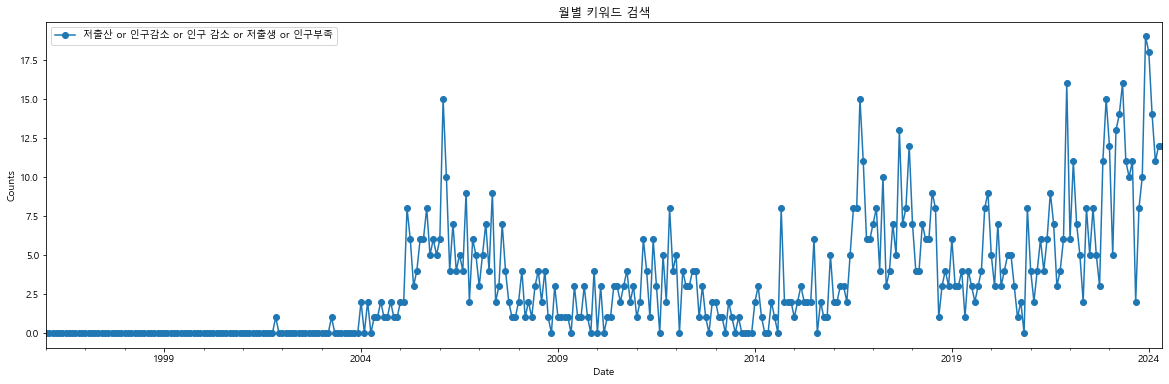

In [112]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
monthly_keywords.plot(marker='o')
plt.title('월별 키워드 검색')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend([" or ".join(keywords)])
plt.show()

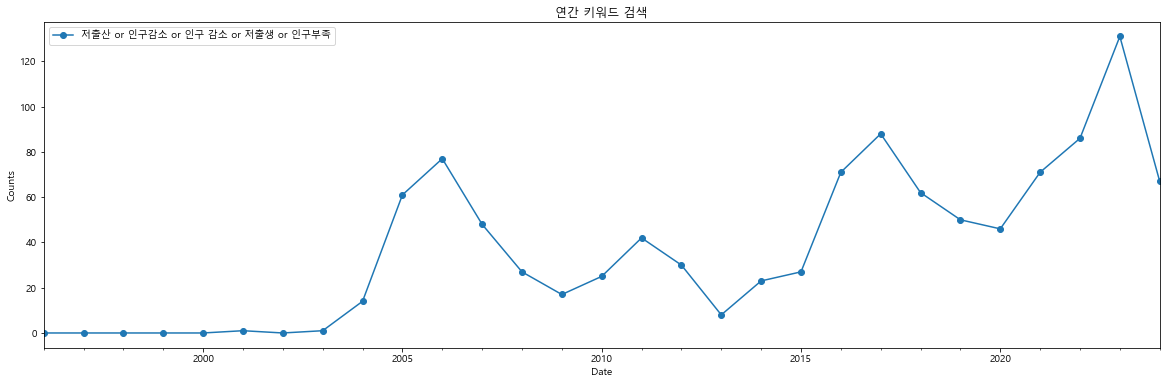

In [113]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
annual_keywords.plot(marker='o')
plt.title('연간 키워드 검색')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend([" or ".join(keywords)])
plt.show()